In [1]:
from scope import GraspSolver, ScopeSolver
import jax.numpy as jnp
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

Here, we consider another loss function for learning sparse precision matrix, i.e., 
$$
\begin{aligned}
&\| {\Sigma}{\Omega^{-1}} - \mathbf{I}_{p\times p} \|_F
\\
\textup{subject to:} \; 
&\Omega \in \mathcal{S}^{++} \\
&\| \Omega \|_0 \leq T \\
\end{aligned}
$$
where $\| \Omega \|_0$ is the number of non-zero entries on upper-diagonal matrix of $\Omega$ and $\mathcal{S}^{++}$ is the space of symmetric positive definite matrix. 

In [2]:
n, p = 150, 30
prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(p, alpha=0.98, smallest_coef=0.3, largest_coef=0.5, random_state=prng)
cov = np.linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(p), cov, size=n)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# sample covariance and precision matrix
cov_sample = np.cov(X.T)
prec_sample = np.linalg.inv(cov_sample)

In [3]:
def graphical_guassian_loss(params, sample_covariance_matrix):
    p = sample_covariance_matrix.shape[0]
    Omega = jnp.zeros((p, p))
    Omega = Omega.at[np.triu_indices(p)].set(params)
    Omega = jnp.where(Omega, Omega, Omega.T)
    return jnp.linalg.norm(jnp.matmul(sample_covariance_matrix, Omega) - np.diag(np.ones(p)), ord='fro')



def convex_solver_cvxpy(
    loss_fn,
    value_and_grad,
    params,
    optim_variable_set,
    data,
):
    p = data.shape[0]
    dim = int(p * (p + 1) / 2)
    s = len(optim_variable_set)

    non_opt_mark_vec = np.ones(dim, dtype=bool)
    non_opt_mark_vec[optim_variable_set] = False
    non_opt_indices_mat = (
        np.triu_indices(p)[0][non_opt_mark_vec],
        np.triu_indices(p)[1][non_opt_mark_vec],
    )

    Omega = cp.Variable((p, p), PSD=True)

    constraints = [
        Omega[non_opt_indices_mat] == np.zeros(dim - s),
    ]

    graphical_guassian_loss = cp.norm(data @ Omega - np.diag(np.ones(p)), "fro")

    prob = cp.Problem(cp.Minimize(graphical_guassian_loss), constraints)
    prob.solve()

    return graphical_guassian_loss.value, Omega.value[np.triu_indices(p)]

In [7]:
solver = GraspSolver(
    dimensionality=int(p * (p + 1) / 2),
    sparsity=np.count_nonzero(prec[np.triu_indices(p)]),
    always_select=np.where(np.triu_indices(p)[0] == np.triu_indices(p)[1])[0],
    convex_solver=convex_solver_cvxpy,
)

solver.solve(
    graphical_guassian_loss,
    cov_sample,
    init_params=np.eye(p)[np.triu_indices(p)],
)

prec_ = np.zeros((p, p))
prec_[np.triu_indices(p)] = solver.params
prec_ = np.where(
    prec_, prec_, prec_.T
)

In [8]:
print('Grasp: ', np.linalg.norm(prec - prec_, ord='fro'))
print('Empirical: ', np.linalg.norm(prec - prec_sample, ord='fro')) 

Grasp:  1.44626070464566
Empirical:  4.40350722846591


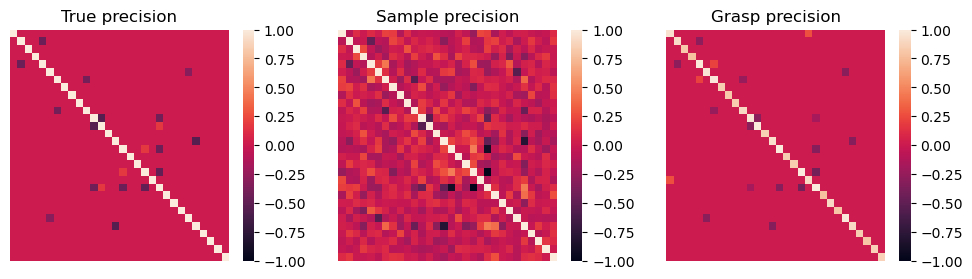

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.heatmap(prec, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('True precision')

sns.heatmap(prec_sample, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Sample precision')

sns.heatmap(prec_, vmin=-1, vmax=1, ax=axes[2])
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Grasp precision')

plt.show()